# Student Admission

In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
import tensorflow as tf
import seaborn as sb
from matplotlib import pyplot as plt
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import imblearn
from yapf.yapflib.yapf_api import FormatCode
from pprint import pformat
def pprint(x):
    print(FormatCode(pformat(x))[0])
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import minmax_scale
data = pd.read_csv('https://stats.idre.ucla.edu/stat/data/binary.csv')

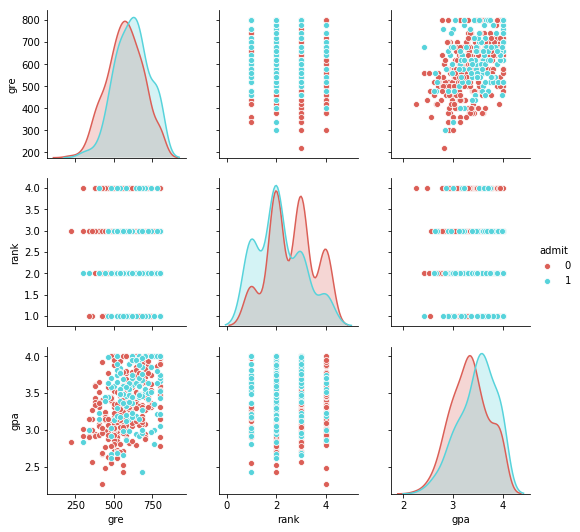

In [2]:
sb.pairplot(data, hue='admit', palette='hls', vars=['gre', 'rank', 'gpa'])

In [3]:
data.groupby('admit').mean()

,gre,gpa,rank
admit,,,
0,573.186813,3.343700,2.641026
1,618.897638,3.489213,2.149606


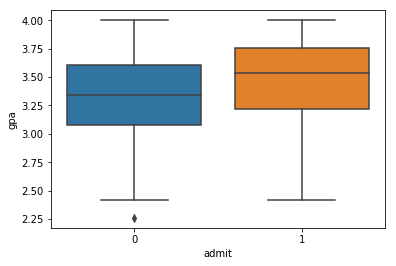

In [4]:
sb.boxplot(x=data.admit, y=data['gpa'])

In [5]:
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)
one_hot_data = pd.concat([one_hot_data, pd.get_dummies(data['admit'], prefix='admit')], axis=1)

# Drop the previous rank column
data = one_hot_data.drop('rank', axis=1)
data = one_hot_data.drop('admit', axis=1)
print(data.shape)

(400, 9)


In [6]:
X = data.iloc[:,[0,1,2,3,4,5,6]]
y = data.iloc[:,[7,8]]

X = minmax_scale(X, feature_range=(0, 1))
X

array([[0.276, 0.776, 0.667, ..., 0.   , 1.   , 0.   ],
       [0.759, 0.81 , 0.667, ..., 0.   , 1.   , 0.   ],
       [1.   , 1.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.414, 0.213, 0.333, ..., 1.   , 0.   , 0.   ],
       [0.828, 0.799, 0.333, ..., 1.   , 0.   , 0.   ],
       [0.655, 0.937, 0.667, ..., 0.   , 1.   , 0.   ]])

In [7]:
over = imblearn.over_sampling.SMOTE(sampling_strategy=0.8, random_state=42)
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.8, random_state=42)
steps = [('o', over), ('u', under)]

pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_balanced, y_balanced = pipeline.fit_resample(X, y=y.to_numpy())
y_balanced = np.eye(2)[y_balanced.flatten()]
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

c:\program files\python37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced, test_size=0.2)
X_train.shape, y_train.shape
X_train_batches, y_train_batches = np.split(X_train,14),np.split(y_train,14)

In [37]:
n_features = X_train.shape[1]
n_labels = y_train.shape[1]

features = tf.placeholder(tf.float32, [None, n_features])
labels = tf.placeholder(tf.float32, [None, n_labels])

w = [
    tf.Variable(tf.random_normal((n_features, 256), stddev=(1/tf.sqrt(float(n_features))), seed=42), name='Weights_layer_0'),
    tf.Variable(tf.random_normal((256, 64), stddev=(1/tf.sqrt(float(256))), seed=42), name='Weights_layer_1'),
    tf.Variable(tf.random_normal((64, 8), stddev=(1/tf.sqrt(float(64))), seed=42), name='Weights_layer_2'),
    tf.Variable(tf.random_normal((8, n_labels), stddev=(1/tf.sqrt(float(8))), seed=42), name='Weights_layer_3'),
]

n_layers = len(w)
b = [
    tf.Variable(tf.random_normal((256,), stddev=0.01, seed=42), name='Bias_layer_0'),
    tf.Variable(tf.random_normal((64,), stddev=0.01, seed=42), name='Bias_layer_1'),
    tf.Variable(tf.random_normal((8,), stddev=0.01, seed=42), name='Bias_layer_2'),
    tf.Variable(tf.random_normal((n_labels,), stddev=0.01, seed=42), name='Bias_layer_3'),
]

In [43]:
def neural_network(input, weights, biases):
    for i in range(n_layers-1):
        layer = tf.add(tf.matmul(input if i==0 else layer, weights[i]),biases[i])
        layer = tf.nn.selu(layer)
        if(i!=0):
            layer = tf.nn.dropout(layer, keep_prob=(0.5 + i/10))
    out_layer = tf.add(tf.matmul(layer, weights[-1]),biases[-1])
    return out_layer

In [48]:
loss_ = []
res = []
prediction = neural_network(features, w, b)
# loss = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(prediction), reduction_indices=1))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=labels))
optim = tf.train.AdadeltaOptimizer(0.05).minimize(loss)
# correct_prediction = tf.equal(tf.round(prediction), labels)
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(prediction), 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
with tf.device('/dml:0'):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(500):
            for m,n in zip(X_train_batches, y_train_batches):
                _, l = sess.run([optim, loss],feed_dict={features: m, labels: n})
            loss_.append(l)
                # pprint(sess.run(w))
                # pprint(sess.run(b))

            acc = sess.run([accuracy], feed_dict={features: X_train, labels: y_train})
            print(i, acc)
        test_accuracy = sess.run(accuracy,feed_dict={features: X_test, labels: y_test})
        print(test_accuracy)
        res = sess.run(tf.sigmoid(prediction),feed_dict={features: X})

0 [0.5510204]
1 [0.55867344]
2 [0.56122446]
3 [0.56122446]
4 [0.5790816]
5 [0.55867344]
6 [0.5688775]
7 [0.58673465]
8 [0.5229592]
9 [0.54846936]
10 [0.5229592]
11 [0.5969388]
12 [0.58928573]
13 [0.53316325]
14 [0.5663265]
15 [0.5637755]
16 [0.58673465]
17 [0.5561224]
18 [0.60459185]
19 [0.5637755]
20 [0.58418363]
21 [0.56122446]
22 [0.56122446]
23 [0.56122446]
24 [0.5408163]
25 [0.5969388]
26 [0.6505102]
27 [0.5688775]
28 [0.58673465]
29 [0.5688775]
30 [0.5561224]
31 [0.58418363]
32 [0.6147959]
33 [0.59438777]
34 [0.5688775]
35 [0.5153061]
36 [0.5535714]
37 [0.57142854]
38 [0.56122446]
39 [0.58418363]
40 [0.6020408]
41 [0.5790816]
42 [0.6020408]
43 [0.59183675]
44 [0.56122446]
45 [0.54846936]
46 [0.5969388]
47 [0.53061223]
48 [0.5688775]
49 [0.5969388]
50 [0.60459185]
51 [0.59183675]
52 [0.55867344]
53 [0.60459185]
54 [0.57142854]
55 [0.60459185]
56 [0.60459185]
57 [0.58418363]
58 [0.5969388]
59 [0.60714287]
60 [0.58418363]
61 [0.6096939]
62 [0.57142854]
63 [0.6020408]
64 [0.60459185]

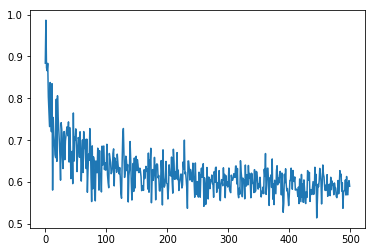

In [49]:
plt.plot(loss_)

In [50]:
d1 = data
d1['pred'] = np.argmax(res, 1)
d1['admit'] = np.argmax(d1.iloc[:,[7,8]].to_numpy(), 1)
d1['res_0'] = res[:,[0]]
d1['res_1'] = res[:,[1]]
d1

,gre,gpa,rank,rank_1,rank_2,rank_3,rank_4,admit_0,admit_1,pred,admit,res_0,res_1
0,380,3.61,3,0,0,1,0,1,0,0,0,0.822865,0.232784
1,660,3.67,3,0,0,1,0,0,1,0,1,0.509649,0.413209
2,800,4.00,1,1,0,0,0,0,1,1,1,0.218805,0.706213
3,640,3.19,4,0,0,0,1,0,1,0,1,0.713674,0.296233
4,520,2.93,4,0,0,0,1,1,0,0,0,0.803616,0.299519
...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,620,4.00,2,0,1,0,0,1,0,1,0,0.474836,0.580369
396,560,3.04,3,0,0,1,0,1,0,0,0,0.792779,0.310936
397,460,2.63,2,0,1,0,0,1,0,0,0,0.799949,0.398979
398,700,3.65,2,0,1,0,0,1,0,1,0,0.487431,0.552744


In [51]:
np.bincount(np.equal(np.argmax(res, 1), np.argmax(d1.iloc[:,[7,8]].to_numpy(), 1)))

array([128, 272], dtype=int64)